In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import random_split
import time
import os
import time
import numpy as np
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
# ======================
#  DATASET & NORMALIZATION
# ======================
train_dir = './data/Training'

# Temporary loader for mean/std
temp_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
temp_dataset = datasets.ImageFolder(train_dir, transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=64, shuffle=False, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))

imgs = torch.cat([img for img, _ in temp_loader])
mean, std = imgs.mean([0, 2, 3]), imgs.std([0, 2, 3])
print("Mean:", mean.item(), "Std:", std.item())

# Final transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    # These 3 transformations are recommended to not get caught up on orientation or lighting
    # Shouldn't use more as too many can distort or cause slower convergence
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    # -------------------------------------------------------------------------------------
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Reload full dataset with final transforms
full_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Loaders
train_labels = [train_dataset.dataset.samples[i][1] for i in train_dataset.indices]
label_counts = Counter(train_labels)
weights = 1. / np.array([label_counts[i] for i in range(len(label_counts))])
sample_weights = [weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights)) # Good for heavy class imbalance & custom CNN which is common w/ medical datasets
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=min(2, os.cpu_count() // 2), pin_memory=(device.type == "cuda"))

print(f"Train images: {len(train_dataset)}, Validation images: {len(val_dataset)}")
print("Classes:", train_dataset.dataset.classes)

Mean: 0.17943531274795532 Std: 0.18682362139225006
Train images: 2296, Validation images: 574
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4, in_channels=1):
        super(BrainTumorCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 112x112
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.1),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2) # 56x56
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2)  # 28x28
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # 1x1
        )

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [6]:
# ======================
# MODEL SETUP
# ======================
model = BrainTumorCNN(num_classes=4, in_channels=1).to(device)
criterion = nn.CrossEntropyLoss() # Can use weight=weights here to have milder imbalance adjustment, don't use with WeightedRandomSampler as it's redundent
# Typical optimizer and scheduler for custom medical CNN, specifies steps and convergence
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

# ======================
# VALIDATION FUNCTION
# ======================
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = correct / total

    print(f'Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc*100:.2f}%')
    return avg_val_loss, avg_val_acc

# ======================
#  SAVE UTIL
# ======================
save_dir = "./data"
def next_version(prefix, ext):
    existing = [int(f.split("_")[-1].split(".")[0])
                for f in os.listdir(os.path.join(save_dir, "models"))
                if f.startswith(prefix) and f.endswith(ext)
                and f.split("_")[-1].split(".")[0].isdigit()]
    return max(existing) + 1 if existing else 1

model_number = next_version("Brain_Tumor_Model_custom", ".pth")
model_path = os.path.join(save_dir, "models", f"Brain_Tumor_Model_custom_{model_number}.pth")
print(f"🧩 Saving model to: {model_path}")

# ======================
# TRAINING LOOP
# ======================
total_start = time.time()
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop_patience = 7
num_epochs = 70

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "training_time": time.time() - total_start
        }
        torch.save(checkpoint, model_path)
        print(f"💾 New best model saved (Val Loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"🕒 No improvement for {epochs_no_improve} epoch(s)")
        if epochs_no_improve >= early_stop_patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

print(f"\n✅ Total Training Time: {(time.time()-total_start)/60:.2f} min")

🧩 Saving model to: ./data\models\Brain_Tumor_Model_custom_1.pth


Epoch [1/70]: 100%|██████████| 72/72 [00:17<00:00,  4.13it/s, loss=1.18]


Validation Loss: 1.1252 | Validation Accuracy: 56.79%
Epoch [1/70] | Train Loss: 1.1932 | Val Loss: 1.1252 | Val Acc: 56.79%
💾 New best model saved (Val Loss: 1.1252)


Epoch [2/70]: 100%|██████████| 72/72 [00:16<00:00,  4.40it/s, loss=0.962]


Validation Loss: 1.0422 | Validation Accuracy: 56.27%
Epoch [2/70] | Train Loss: 1.0397 | Val Loss: 1.0422 | Val Acc: 56.27%
💾 New best model saved (Val Loss: 1.0422)


Epoch [3/70]: 100%|██████████| 72/72 [00:16<00:00,  4.38it/s, loss=1.09] 


Validation Loss: 0.9317 | Validation Accuracy: 63.07%
Epoch [3/70] | Train Loss: 0.9317 | Val Loss: 0.9317 | Val Acc: 63.07%
💾 New best model saved (Val Loss: 0.9317)


Epoch [4/70]: 100%|██████████| 72/72 [00:16<00:00,  4.28it/s, loss=1.06] 


Validation Loss: 0.9141 | Validation Accuracy: 60.80%
Epoch [4/70] | Train Loss: 0.8954 | Val Loss: 0.9141 | Val Acc: 60.80%
💾 New best model saved (Val Loss: 0.9141)


Epoch [5/70]: 100%|██████████| 72/72 [00:16<00:00,  4.25it/s, loss=0.804]


Validation Loss: 0.8376 | Validation Accuracy: 65.68%
Epoch [5/70] | Train Loss: 0.8589 | Val Loss: 0.8376 | Val Acc: 65.68%
💾 New best model saved (Val Loss: 0.8376)


Epoch [6/70]: 100%|██████████| 72/72 [00:16<00:00,  4.32it/s, loss=0.654]


Validation Loss: 0.8487 | Validation Accuracy: 63.76%
Epoch [6/70] | Train Loss: 0.8145 | Val Loss: 0.8487 | Val Acc: 63.76%
🕒 No improvement for 1 epoch(s)


Epoch [7/70]: 100%|██████████| 72/72 [00:16<00:00,  4.31it/s, loss=0.753]


Validation Loss: 0.7774 | Validation Accuracy: 68.47%
Epoch [7/70] | Train Loss: 0.7814 | Val Loss: 0.7774 | Val Acc: 68.47%
💾 New best model saved (Val Loss: 0.7774)


Epoch [8/70]: 100%|██████████| 72/72 [00:17<00:00,  4.13it/s, loss=0.792]


Validation Loss: 0.8301 | Validation Accuracy: 62.54%
Epoch [8/70] | Train Loss: 0.7492 | Val Loss: 0.8301 | Val Acc: 62.54%
🕒 No improvement for 1 epoch(s)


Epoch [9/70]: 100%|██████████| 72/72 [00:17<00:00,  4.21it/s, loss=0.705]


Validation Loss: 0.8063 | Validation Accuracy: 66.90%
Epoch [9/70] | Train Loss: 0.7345 | Val Loss: 0.8063 | Val Acc: 66.90%
🕒 No improvement for 2 epoch(s)


Epoch [10/70]: 100%|██████████| 72/72 [00:16<00:00,  4.26it/s, loss=0.737]


Validation Loss: 0.7744 | Validation Accuracy: 67.60%
Epoch [10/70] | Train Loss: 0.7364 | Val Loss: 0.7744 | Val Acc: 67.60%
💾 New best model saved (Val Loss: 0.7744)


Epoch [11/70]: 100%|██████████| 72/72 [00:17<00:00,  4.09it/s, loss=0.78] 


Validation Loss: 0.9725 | Validation Accuracy: 56.27%
Epoch [11/70] | Train Loss: 0.7178 | Val Loss: 0.9725 | Val Acc: 56.27%
🕒 No improvement for 1 epoch(s)


Epoch [12/70]: 100%|██████████| 72/72 [00:16<00:00,  4.27it/s, loss=0.883]


Validation Loss: 0.8376 | Validation Accuracy: 64.98%
Epoch [12/70] | Train Loss: 0.6741 | Val Loss: 0.8376 | Val Acc: 64.98%
🕒 No improvement for 2 epoch(s)


Epoch [13/70]: 100%|██████████| 72/72 [00:17<00:00,  4.15it/s, loss=0.593]


Validation Loss: 0.8312 | Validation Accuracy: 64.98%
Epoch [13/70] | Train Loss: 0.6401 | Val Loss: 0.8312 | Val Acc: 64.98%
🕒 No improvement for 3 epoch(s)


Epoch [14/70]: 100%|██████████| 72/72 [00:16<00:00,  4.36it/s, loss=0.651]


Validation Loss: 0.9446 | Validation Accuracy: 54.18%
Epoch [14/70] | Train Loss: 0.6748 | Val Loss: 0.9446 | Val Acc: 54.18%
🕒 No improvement for 4 epoch(s)


Epoch [15/70]: 100%|██████████| 72/72 [00:16<00:00,  4.30it/s, loss=0.565]


Validation Loss: 0.6887 | Validation Accuracy: 69.51%
Epoch [15/70] | Train Loss: 0.6076 | Val Loss: 0.6887 | Val Acc: 69.51%
💾 New best model saved (Val Loss: 0.6887)


Epoch [16/70]: 100%|██████████| 72/72 [00:17<00:00,  4.16it/s, loss=0.512]


Validation Loss: 0.7167 | Validation Accuracy: 68.99%
Epoch [16/70] | Train Loss: 0.6152 | Val Loss: 0.7167 | Val Acc: 68.99%
🕒 No improvement for 1 epoch(s)


Epoch [17/70]: 100%|██████████| 72/72 [00:16<00:00,  4.29it/s, loss=0.733]


Validation Loss: 0.7404 | Validation Accuracy: 66.38%
Epoch [17/70] | Train Loss: 0.6022 | Val Loss: 0.7404 | Val Acc: 66.38%
🕒 No improvement for 2 epoch(s)


Epoch [18/70]: 100%|██████████| 72/72 [00:16<00:00,  4.31it/s, loss=0.554]


Validation Loss: 0.8494 | Validation Accuracy: 61.50%
Epoch [18/70] | Train Loss: 0.5979 | Val Loss: 0.8494 | Val Acc: 61.50%
🕒 No improvement for 3 epoch(s)


Epoch [19/70]: 100%|██████████| 72/72 [00:16<00:00,  4.27it/s, loss=0.919]


Validation Loss: 0.7877 | Validation Accuracy: 64.81%
Epoch [19/70] | Train Loss: 0.5634 | Val Loss: 0.7877 | Val Acc: 64.81%
🕒 No improvement for 4 epoch(s)


Epoch [20/70]: 100%|██████████| 72/72 [00:16<00:00,  4.40it/s, loss=0.467]


Validation Loss: 0.6888 | Validation Accuracy: 73.17%
Epoch [20/70] | Train Loss: 0.5098 | Val Loss: 0.6888 | Val Acc: 73.17%
🕒 No improvement for 5 epoch(s)


Epoch [21/70]: 100%|██████████| 72/72 [00:16<00:00,  4.40it/s, loss=0.691]


Validation Loss: 0.8152 | Validation Accuracy: 66.03%
Epoch [21/70] | Train Loss: 0.5309 | Val Loss: 0.8152 | Val Acc: 66.03%
🕒 No improvement for 6 epoch(s)


Epoch [22/70]: 100%|██████████| 72/72 [00:16<00:00,  4.38it/s, loss=0.996]


Validation Loss: 0.8568 | Validation Accuracy: 63.07%
Epoch [22/70] | Train Loss: 0.5251 | Val Loss: 0.8568 | Val Acc: 63.07%
🕒 No improvement for 7 epoch(s)

🛑 Early stopping at epoch 22

✅ Total Training Time: 9.54 min


In [8]:
# ======================
# LOAD SPECIFIC SAVED MODEL
# ======================

import os
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create the same model architecture used during training
save_dir = "./data"
model_number = 1 # Change to version you want
model_path = os.path.join(save_dir, "models", f"Brain_Tumor_Model_custom_{model_number}.pth")

print(f"🧩 Loading custom CNN model from: {model_path}")

model = BrainTumorCNN(num_classes=4, in_channels=1).to(device)

# ✅ Load full checkpoint (not just weights)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
training_time = checkpoint.get("training_time", 0)
epoch_trained = checkpoint.get("epoch", "N/A")

print(f"✅ Model loaded from checkpoint trained for {training_time/60:.2f} minutes "
      f"({epoch_trained} epochs)")

# Set to evaluation mode
model.eval()
print("✅ Model ready for inference.")

🧩 Loading custom CNN model from: ./data\models\Brain_Tumor_Model_custom_1.pth
✅ Model loaded from checkpoint trained for 6.54 minutes (15 epochs)
✅ Model ready for inference.


C:\Users\mwm06\AppData\Local\Temp\ipykernel_11600\3900824450.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



✅ Test Accuracy: 50.25%

Classification Report:
                   precision    recall  f1-score   support

    glioma_tumor       0.90      0.09      0.16       100
meningioma_tumor       0.44      0.65      0.52       115
        no_tumor       0.58      0.50      0.54       105
 pituitary_tumor       0.50      0.82      0.62        74

        accuracy                           0.50       394
       macro avg       0.61      0.52      0.46       394
    weighted avg       0.61      0.50      0.46       394



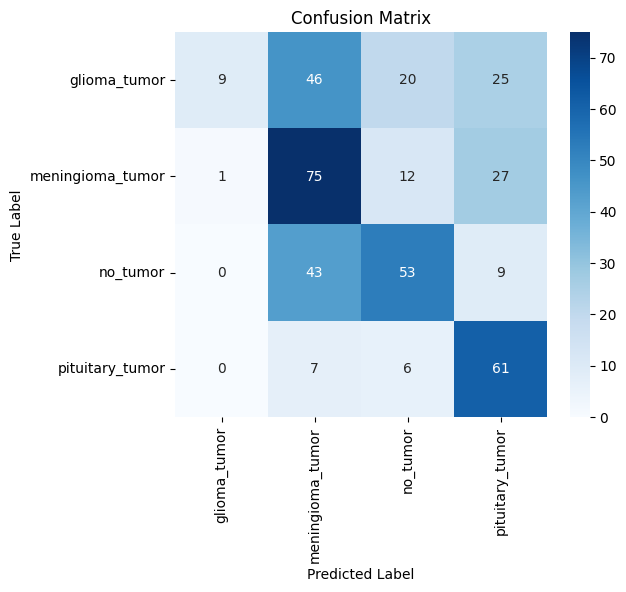

Per-class Precision: [0.9        0.43859649 0.58241758 0.5       ]
Per-class Recall: [0.09       0.65217391 0.5047619  0.82432432]
📄 Report saved to: ./data\reports\eval_report_1.txt


In [ ]:
# ======================
# TEST + REPORT
# ======================
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_dir = "./data/Testing"
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
class_names = test_dataset.classes

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)
acc = (y_true == y_pred).sum() / len(y_true)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)

report_path = os.path.join(save_dir, "reports", f"eval_report_custom_{model_number}.txt")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

metrics = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2,3])
print("Per-class Precision:", metrics[0])
print("Per-class Recall:", metrics[1])

# ======================
# SAVE REPORT
# ======================
with open(report_path, "w") as f:
    f.write(f"Model file: {os.path.basename(model_path)}\n")
    f.write(f"Total Training Time: {training_time/60:.2f} minutes\n")
    f.write(f"\nTest Accuracy: {acc*100:.2f}%\n\n")
    f.write(report)
print(f"📄 Report saved to: {report_path}")